In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import laspy
import os

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.utils.validation import check_is_fitted, check_array
from sklearn.metrics.pairwise import pairwise_distances

In [79]:
class CustomClustering(BaseEstimator, ClusterMixin): # Step 1: Create a template for custom clustering algorithms
    """
    A custom clustering algorithm that clusters data using a median-based
    approach, similar to k-means but using medians as cluster centers.
    """
    def __init__(self, n_clusters=2, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, y=None):
        X = check_array(X)
        n_samples, n_features = X.shape

        # Randomly initialize cluster centers from the data points
        rng = np.random.default_rng()
        initial_idx = rng.choice(n_samples, self.n_clusters, replace=False)
        self.cluster_centers_ = X[initial_idx]

        for i in range(self.max_iter):
            distances = pairwise_distances(X, self.cluster_centers_, metric="manhattan")
            labels = np.argmin(distances, axis=1)
            new_centers = np.array([
                np.median(X[labels == k], axis=0) if np.any(labels == k) else self.cluster_centers_[k]
                for k in range(self.n_clusters)
            ])
            if np.all(np.abs(new_centers - self.cluster_centers_) < self.tol):
                break
            self.cluster_centers_ = new_centers

        self.labels_ = labels
        return self

    def predict(self, X):
        check_is_fitted(self, 'cluster_centers_')
        distances = pairwise_distances(X, self.cluster_centers_, metric="manhattan")
        return np.argmin(distances, axis=1)

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

In [80]:
class NestedClustering:
    def __init__(self, clustering_stages):
        self.clustering_stages = clustering_stages

    def fit(self, X, y=None):
        
        self.stage_labels = []  # Store labels for each stage
        self.final_labels = np.zeros(X.shape[0], dtype=int)  # Final labels
        cluster_offset = 0  # Offset to ensure unique labels across clusters
        current_data = X  # Current data to process
        current_labels = np.zeros(X.shape[0], dtype=int)  # Initialize labels

        for stage_idx, stage in enumerate(self.clustering_stages):
            new_labels = np.zeros_like(current_labels)  # New labels for this stage
            unique_clusters = np.unique(current_labels)  # Unique clusters in current stage

            for cluster_id in unique_clusters:
                # Get data points for the current cluster
                cluster_data = current_data[current_labels == cluster_id]
                if len(cluster_data) == 0:  # Skip empty clusters
                    continue
                
                # Fit the clustering algorithm to the current cluster
                stage.fit(cluster_data)
                cluster_stage_labels = stage.labels_

                # Assign new labels offset by cluster_offset
                new_labels[current_labels == cluster_id] = (
                    cluster_stage_labels + cluster_offset
                )

                # Update cluster offset for the next unique label
                cluster_offset += len(np.unique(cluster_stage_labels))
            
            # Store the stage labels and update current labels
            self.stage_labels.append(new_labels.copy())
            current_labels = new_labels
            current_data = X  # Keep the original data for clustering
            

        # Reindex final labels to start from zero
        unique_labels = np.unique(current_labels)
        reindex_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
        self.final_labels = np.array([reindex_map[label] for label in current_labels])
        return self


    def predict(self, X):
        """
        Predict clusters for new data (optional, not implemented).
        """
        raise NotImplementedError("Prediction is not implemented for NestedClustering.")

In [81]:
def plot_clusters(X, labels, title="Cluster Plot"): # Plot results of the last stage of clustering
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=5, label=f"{label}")
    plt.title(title)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()
    

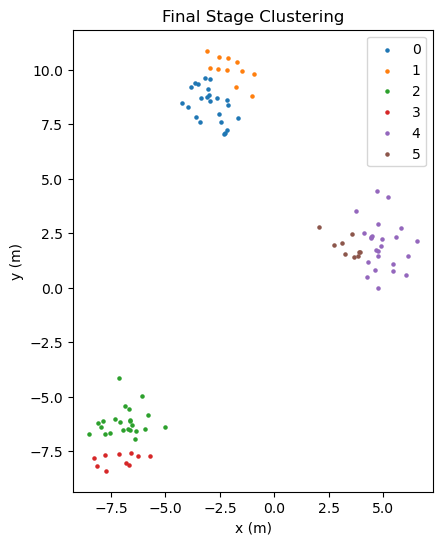

In [84]:
# Sample data
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, centers=3, random_state=42)

pipeline = NestedClustering([
    KMeans(n_clusters=3, random_state=42),  # First clustering stage
    AgglomerativeClustering(n_clusters=2),
    CustomClustering(n_clusters=1)
])

# Fit the pipeline
pipeline.fit(X)

# Plot the final clusters
plot_clusters(X, pipeline.final_labels, title="Final Stage Clustering")

## Now with real data

In [3]:
basePath = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/"
neighborhood = "Test_70_el Besòs i el Maresme"
parcelsFolder = basePath + "/Results/" + neighborhood + "/Parcels/"

folders = os.listdir(parcelsFolder)

for i in range(len(folders[0:1])):
    subfolder = parcelsFolder + "/" + folders[i] + "/"
    fullDF = []
    for construction in [x for x in os.listdir(subfolder)[0:1] if os.path.isdir(subfolder + x)]:
        lazFile = subfolder + construction + "/Map files/" + construction + ".laz"
      
        lasDF = laspy.read(lazFile)
        data = lasDF.xyz

print(data)

[[4.34148948e+05 4.58489356e+06 6.14800000e+00]
 [4.34148572e+05 4.58489351e+06 5.09800000e+00]
 [4.34148495e+05 4.58489309e+06 4.77000000e+00]
 ...
 [4.34077874e+05 4.58485233e+06 4.70700000e+00]
 [4.34077414e+05 4.58485212e+06 4.79800000e+00]
 [4.34076704e+05 4.58485152e+06 5.63400000e+00]]


In [21]:
class heightSplit(BaseEstimator, ClusterMixin): # Step 1: Create a template for custom clustering algorithms
    def __init__(self, distance_threshold = 0.45):
        self.distance_threshold = distance_threshold
        pass

    def fit(self, X):
        X = check_array(X)
        n_samples, n_features = X.shape

        X = X[X[:, 2].argsort()]
        
        deltaZ = np.diff(X[:,2], prepend=0)
        
        labels = np.zeros_like(deltaZ, dtype=int)

        current_label = 0
        for i in range(1, len(deltaZ)):
            if deltaZ[i] > self.distance_threshold:
                current_label += 1
            labels[i] = current_label

        self.labels_ = labels
        return self

    def predict(self, X):
        pass

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

In [85]:
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_squared_error

class kPlanes(BaseEstimator, ClusterMixin): # Step 1: Create a template for custom clustering algorithms
    def __init__(self, num_iterations = 10, max_planes=20):
        self.num_iterations = num_iterations
        self.max_planes = max_planes

        self.best_planes = None
        self.best_score = float('inf')

        pass

    def fit_plane(self, X):
        """
        Fit a plane to the data using RANSAC to find inliers.
        """
        # Define a plane model: z = ax + by + d
        def plane_model(X):
            A = np.c_[X[:, 0], X[:, 1], np.ones(X.shape[0])]
            return A

        # RANSAC Regressor to fit the plane
        ransac = RANSACRegressor(residual_threshold=0.15)
        ransac.fit(plane_model(X), X[:, 2])

        inlier_mask = ransac.inlier_mask_
        coefficients = ransac.estimator_.coef_  # [a, b]
        intercept = ransac.estimator_.intercept_  # c

        return coefficients, intercept, inlier_mask
    
    def farthest_point_sampling(self, X, n_planes):
        """
        Select `n_planes` points such that each point is as far as possible
        from the already selected points.
        """
        # Randomly select the first point
        selected_points = [np.random.choice(X.shape[0])]
        
        # Select the remaining points
        for _ in range(1, n_planes):
            # Compute the distances from all points to the closest selected point
            distances = np.min(np.linalg.norm(X[:, None] - X[selected_points], axis=2), axis=1)
            
            # Select the point that is farthest from the selected points
            farthest_point = np.argmax(distances)
            selected_points.append(farthest_point)

        return np.array(selected_points) 

    def fit(self, X):
        n_planes = 1
        best_score = float('inf')
        best_classification = []
        while n_planes <= self.max_planes: # Maybe another termination
            best_score_n = float('inf')
            best_classification_n = [] # Labels

            # for i in range(self.num_iterations):
                # Sample n_planes points by distance
                # For each sampled point, sample two more that are close to it
                
                # For each triplet of points, fit plane
                # For each plane, find inliers
                
                # While not converging: #Convergence will be achieved once all points do not change label
                    # Fit plane
                    # Select inliers

                # Compute score
                # score = rmse?
                # if(score > best_score_n):
                    # best_score_n = best_score_n
                    # best_classification_n = labels    

            # if(best_score_n > best_score):
            #     best_score = best_score_n
            #     best_classification = best_classification_n


        return self

    def predict(self, X):
        pass

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

In [30]:
class removeAnomalies(BaseEstimator, ClusterMixin): # Step 1: Create a template for custom clustering algorithms
    def __init__(self):
        pass

    def fit(self, X):
        return self

    def predict(self, X):
        pass

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

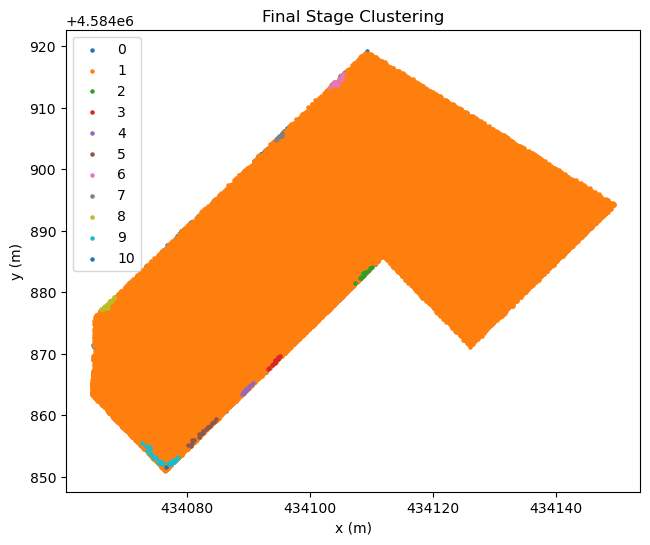

In [77]:
from sklearn.cluster import DBSCAN

pipeline = NestedClustering([
    heightSplit(distance_threshold=0.45),  # First clustering stage
    DBSCAN(eps=1.5, min_samples=8),
    # kPlanes(),
    # removeAnomalies(),
])

# Fit the pipeline
pipeline.fit(data)

# Plot the final clusters
plot_clusters(data, pipeline.final_labels, title="Final Stage Clustering")

## Voronoi

In [33]:
data, pipeline.final_labels

(array([[4.34148948e+05, 4.58489356e+06, 6.14800000e+00],
        [4.34148572e+05, 4.58489351e+06, 5.09800000e+00],
        [4.34148495e+05, 4.58489309e+06, 4.77000000e+00],
        ...,
        [4.34077874e+05, 4.58485233e+06, 4.70700000e+00],
        [4.34077414e+05, 4.58485212e+06, 4.79800000e+00],
        [4.34076704e+05, 4.58485152e+06, 5.63400000e+00]]),
 array([0, 0, 0, ..., 1, 1, 2]))

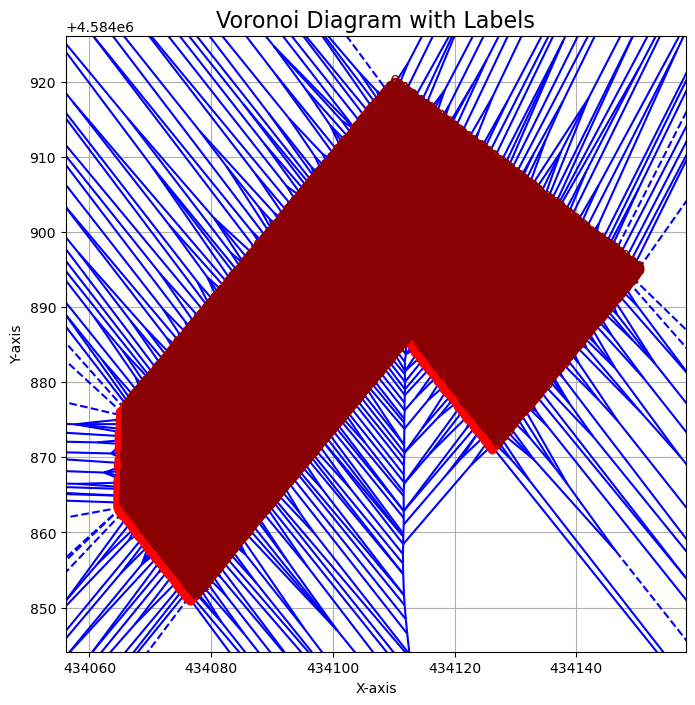

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Example data: Replace these with your own arrays
points = data[:,:2]  # Array of x, y points
labels = pipeline.final_labels

# Create the Voronoi diagram
vor = Voronoi(points)

# Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1.5)

# Overlay the points and labels
for point, label in zip(points, labels):
    ax.plot(point[0], point[1], 'ro')  # Plot points
    ax.text(point[0] + 0.1, point[1] + 0.1, label, fontsize=12, color='darkred')  # Add labels

# Add title and axis labels
ax.set_title('Voronoi Diagram with Labels', fontsize=16)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_aspect('equal')
plt.grid()
plt.show()


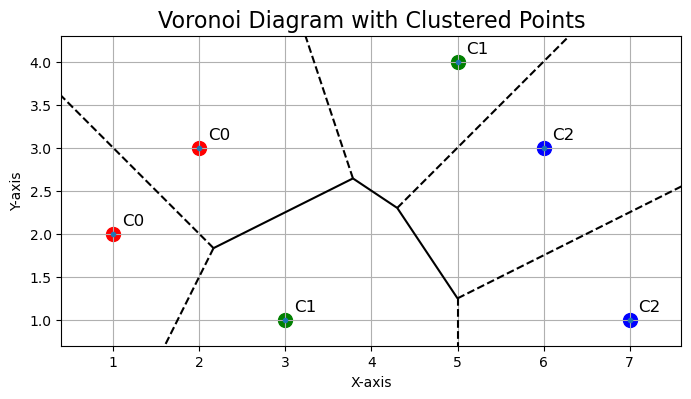

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Example data: Replace with your specific arrays
points_3d = np.array([
    [1, 2, 5], [2, 3, 4], [3, 1, 3], [5, 4, 2], [7, 1, 6], [6, 3, 8]
])  # Array of x, y, z points
clusters = [0, 0, 1, 1, 2, 2]  # Cluster assignments for each point

# Discard the z-coordinate
points_2d = points_3d[:, :2]

# Create the Voronoi diagram
vor = Voronoi(points_2d)

# Define a color map for clusters
colors = ['red', 'green', 'blue']
cluster_colors = [colors[c] for c in clusters]

# Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1.5)

# Overlay the points and cluster labels
for point, cluster, color in zip(points_2d, clusters, cluster_colors):
    ax.scatter(point[0], point[1], color=color, s=100)  # Plot points with cluster color and no border
    ax.text(point[0] + 0.1, point[1] + 0.1, f'C{cluster}', fontsize=12, color='black')  # Label clusters

# Add title and axis labels
ax.set_title('Voronoi Diagram with Clustered Points', fontsize=16)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_aspect('equal')
plt.grid()
plt.show()


In [59]:
vor.vertices

array([[2.16666667, 1.83333333],
       [3.78571429, 2.64285714],
       [5.        , 1.25      ],
       [4.3       , 2.3       ]])

In [60]:
vor.ridge_vertices

[[0, 1], [-1, 0], [-1, 1], [-1, 0], [2, 3], [-1, 2], [-1, 3], [-1, 2], [1, 3]]

/home/jaumeasensio/anaconda3/envs/qgis_stable/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


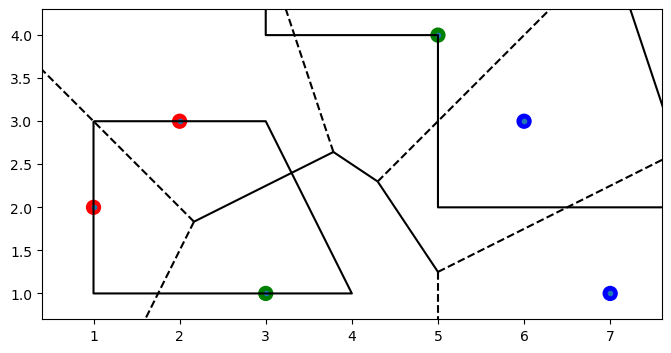

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd

# Example data: Replace with your specific arrays
points_3d = np.array([
    [1, 2, 5], [2, 3, 4], [3, 1, 3], [5, 4, 2], [7, 1, 6], [6, 3, 8]
])  # Array of x, y, z points
clusters = [0, 0, 1, 1, 2, 2]  # Cluster assignments for each point

# Discard the z-coordinate
points_2d = points_3d[:, :2]

# Define a complex geometry (example: union of polygons forming an irregular shape)
geometry = unary_union([
    Polygon([(1, 1), (4, 1), (3, 3), (1, 3)]),
    Polygon([(5, 2), (8, 2), (7, 5), (5, 5)]),
    Polygon([(3, 4), (6, 4), (5, 7), (3, 7)])
])

# Function to clip Voronoi regions with the geometry
def clip_voronoi(vor, geometry):
    polygons = []
    for region_idx in vor.regions:
        if not region_idx or -1 in region_idx:
            continue
        region = [vor.vertices[i] for i in region_idx]
        poly = Polygon(region)
        if poly.is_valid:
            clipped = poly.intersection(geometry)
            if not clipped.is_empty:
                polygons.append(clipped)
    return polygons

# Create Voronoi regions and clip them
vor = Voronoi(points_2d)
clipped_polygons = clip_voronoi(vor, geometry)

# Define a color map for clusters
colors = ['red', 'green', 'blue']
cluster_colors = [colors[c] for c in clusters]

# Create a GeoDataFrame to save to GeoPackage
gdf = gpd.GeoDataFrame({'geometry': clipped_polygons})
gdf.to_file('voronoi_clipped.gpkg', driver='GPKG')

# Plot clipped Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))

for polygon in clipped_polygons:
    ax.plot(*polygon.exterior.xy, color='blue', linewidth=1)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1.5)
ax.scatter(points_2d[:, 0], points_2d[:, 1], color=cluster_colors, s=100)
gpd.GeoSeries(geometry).boundary.plot(ax=ax, color='black')  # Plot boundary
ax.set_aspect('equal')
plt.show()


In [56]:
len(vor.regions)

7

/home/jaumeasensio/anaconda3/envs/qgis_stable/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


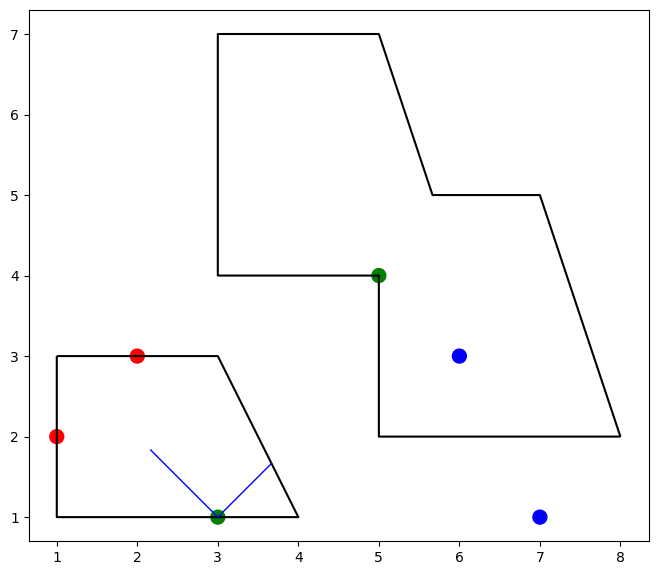

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd

# Example data: Replace with your specific arrays
points_3d = np.array([
    [1, 2, 5], [2, 3, 4], [3, 1, 3], [5, 4, 2], [7, 1, 6], [6, 3, 8]
])  # Array of x, y, z points
clusters = [0, 0, 1, 1, 2, 2]  # Cluster assignments for each point

# Discard the z-coordinate
points_2d = points_3d[:, :2]

# Define a complex geometry (example: union of polygons forming an irregular shape)
geometry = unary_union([
    Polygon([(1, 1), (4, 1), (3, 3), (1, 3)]),
    Polygon([(5, 2), (8, 2), (7, 5), (5, 5)]),
    Polygon([(3, 4), (6, 4), (5, 7), (3, 7)])
])

# Function to clip Voronoi regions with the geometry
def clip_voronoi(vor, geometry):
    polygons = []
    for region_idx in vor.regions:
        if not region_idx or -1 in region_idx:
            continue
        region = [vor.vertices[i] for i in region_idx if i != -1]
        poly = Polygon(region)
        if poly.is_valid:
            clipped = poly.intersection(geometry)
            if not clipped.is_empty:
                polygons.append(clipped)
    
    # Handle infinite edges by constructing lines to the geometry boundary
    for point_idx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        if -1 in simplex:  # Check for infinite ridge
            i = simplex[0] if simplex[1] == -1 else simplex[1]
            if i >= 0:
                start = vor.vertices[i]
                midpoint = vor.points[point_idx].mean(axis=0)
                direction = start - midpoint
                direction = direction / np.linalg.norm(direction)
                far_point = start + direction * 100  # Extend the line far enough
                line = LineString([start, far_point])
                clipped_line = line.intersection(geometry)
                if not clipped_line.is_empty:
                    polygons.append(clipped_line)
    return polygons

# Create Voronoi regions and clip them
vor = Voronoi(points_2d)
clipped_polygons = clip_voronoi(vor, geometry)

# Define a color map for clusters
colors = ['red', 'green', 'blue']
cluster_colors = [colors[c] for c in clusters]

# Create a GeoDataFrame to save to GeoPackage
gdf = gpd.GeoDataFrame({'geometry': clipped_polygons})
gdf.to_file('voronoi_clipped.gpkg', driver='GPKG')

# Plot clipped Voronoi diagram
fig, ax = plt.subplots(figsize=(8, 8))
gpd.GeoSeries(geometry).boundary.plot(ax=ax, color='black')  # Plot boundary
for polygon in clipped_polygons:
    if isinstance(polygon, Polygon):
        ax.plot(*polygon.exterior.xy, color='blue', linewidth=1)
    elif isinstance(polygon, LineString):
        ax.plot(*polygon.xy, color='blue', linewidth=1)
ax.scatter(points_2d[:, 0], points_2d[:, 1], color=cluster_colors, s=100)
plt.show()
